In [3]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from autograd import grad

In [4]:
def generate_1D_design_matrix(x, poly_deg, intercept=True):

    n = len(x)
    x = x.reshape(-1, 1)

    X = np.ones(shape=(n, poly_deg+1))
    for p in range(poly_deg):
        X[:, p+1] = x[:, 0]**(p+1)
    
    if intercept == False:
        return np.delete(X, 0, axis=1)
    return X

def cost_func(X, y, beta, lmbda = 0):
    return np.mean((y - X @ beta)**2) + lmbda * np.sqrt(np.sum(beta**2))**2


## Plain Gradient Descent

In [40]:
def GradientDescent(X, y, n_iter = 1000, lmbda = 0, tol = 1e-8, momentum = 0, analytical_grad = False, eta: float|None = None):
    n = len(y)
    theta = np.random.randn(X.shape[1], 1)

    if eta is None:
        H = (2/n) * X.T @ X + 2 * lmbda * np.eye(X.shape[1])
        eigenvalues, _ = np.linalg.eig(H)
        eta = 1/eigenvalues.max()

    gradient = grad(cost_func, 2)

    change = 0
    for i in range(n_iter):
        if analytical_grad:
            gradients = (2/n) * X.T @ (X @ theta - y) + 2 * lmbda * theta
        else:
            gradients = gradient(X, y, theta, lmbda)
        new_change = eta * gradients + momentum * change
        theta -= new_change
        change = new_change
        if np.linalg.norm(theta) <= tol:  
            return theta

    return theta

MSE for plain GD with autograd: 1.08737
MSE for plain GD with momentum: 3.46105
MSE for plain GD with analytical gradient: 1.07596
MSE for plain GD with momentum and analytical gradient: 3.69218


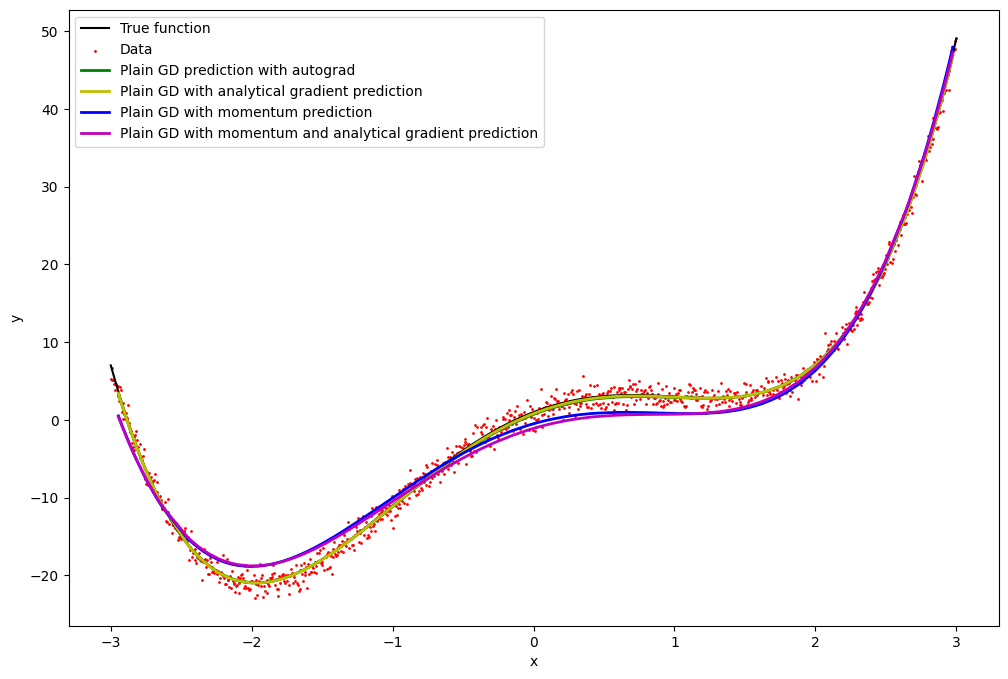

In [73]:
np.random.seed(2020)
n = 1000
x = np.linspace(-3, 3, n)
noise = np.random.normal(0, 1.0, n)
y_true = x**4 - 6*x**2 + 7*x + 1
y = y_true + noise
y = y.reshape(-1, 1)
poly_deg = 4
iterations = 10000
momentum = 0.3
include_intercept = True
lmbda = 0.01        # If lmbda = 0, then we get OLS
tol = 1e-8
step_size = 0.0001

X = generate_1D_design_matrix(x, poly_deg, intercept=include_intercept)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


beta_plainGD = GradientDescent(X_train, y_train, n_iter = iterations, lmbda=0)
beta_plainGD_analytical = GradientDescent(X_train, y_train, n_iter = iterations, lmbda=0, analytical_grad=True)
beta_plainGD_momentum = GradientDescent(X_train, y_train, n_iter = iterations, lmbda=0, momentum=momentum, eta=step_size)
beta_plainGD_momentum_analytical = GradientDescent(X_train, y_train, n_iter = iterations, lmbda=0, momentum=momentum, eta=step_size, analytical_grad=True)

# Sort data for plotting
x_test = np.linspace(-3, 3, X_test.shape[0])
if include_intercept:
    indices = np.argsort(X_test[:, 1])
    x_test = X_test[:, 1][indices]
else:
    indices = np.argsort(X_test[:, 0])
    x_test = X_test[:, 0][indices]

indices = np.argsort(X_test[:, 1])

x_test = X_test[:, 1][indices]
y_plainGD = X_test[indices] @ beta_plainGD
y_plainGD_analytical = X_test[indices] @ beta_plainGD_analytical
y_plainGD_momentum = X_test[indices] @ beta_plainGD_momentum
y_plainGD_momentum_analytical = X_test[indices] @ beta_plainGD_momentum_analytical

mse = np.mean((y_test - X_test @ beta_plainGD)**2)
print(f'MSE for plain GD with autograd: {mse:.5f}')
mse = np.mean((y_test - X_test @ beta_plainGD_momentum)**2)
print(f'MSE for plain GD with momentum: {mse:.5f}')
mse = np.mean((y_test - X_test @ beta_plainGD_analytical)**2)
print(f'MSE for plain GD with analytical gradient: {mse:.5f}')
mse = np.mean((y_test - X_test @ beta_plainGD_momentum_analytical)**2)
print(f'MSE for plain GD with momentum and analytical gradient: {mse:.5f}')

# Plot data and prediction
plt.figure(figsize=(12, 8))
plt.plot(x, y_true, c='k', label='True function')
plt.scatter(x, y, s=1, c='r', label='Data')
plt.plot(x_test, y_plainGD, c ='g', lw=2, label='Plain GD prediction with autograd')
plt.plot(x_test, y_plainGD_analytical, c ='y', lw=2, label='Plain GD with analytical gradient prediction')
plt.plot(x_test, y_plainGD_momentum, c ='b', lw=2, label='Plain GD with momentum prediction')
plt.plot(x_test, y_plainGD_momentum_analytical, c ='m', lw=2, label='Plain GD with momentum and analytical gradient prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()


## Stochastic Gradient Descent

In [102]:
def learning_schedule_decay(t, t0, t1):
    return t0/(t1 + t)

def StochasticGradientDescent(X, y, M, n_epochs = 10, lmbda = 0, learning_schedule_params = (0, 0), momentum=momentum, optimizer='SGD', delta = 1e-8):
    n = len(y)
    m = int(n/M)    # mini-batches

    H = (2/n) * X.T @ X + 2 * lmbda * np.eye(X.shape[1])
    eigenvalues, _ = np.linalg.eig(H)
    eta = 1/eigenvalues.max()

    t0, t1 = learning_schedule_params

    theta = np.random.randn(X.shape[1], 1)
    gradient = grad(cost_func, 2)

    match optimizer:
        case 'SDG':
            for epoch in range(n_epochs):
                change = 0
                for i in range(m):
                    k = M*np.random.randint(m)    #k'th mini-batch
                    X_k = X[k:k+M]
                    y_k = y[k:k+M]
                    gradients = (1/M)*gradient(X_k, y_k, theta, lmbda)
                    t = epoch*m + i
                    eta = learning_schedule_decay(t, t0, t1)
                    update = eta * gradients + momentum * change
                    theta -= update
                    change = update
        
        case 'adagrad':
            for epoch in range(n_epochs):
                r = 0
                change = 0
                for i in range(m):
                    k = M*np.random.randint(m)    #k'th mini-batch
                    X_k = X[k:k+M]
                    y_k = y[k:k+M]
                    gradients = (1/M)*gradient(X_k, y_k, theta, lmbda)
                    t = epoch*m + i
                    r += gradients**2
                    eta = learning_schedule_decay(t, t0, t1)
                    update = (gradients*eta + momentum*change)/(delta + np.sqrt(r)) 
                    theta -= update
                    change = update
        
        case 'rmsprop':
            rho = 0.99
            for epoch in range(n_epochs):
                r = 0
                change = 0
                for i in range(m):
                    k = M*np.random.randint(m)    #k'th mini-batch
                    X_k = X[k:k+M]
                    y_k = y[k:k+M]
                    gradients = (1/M)*gradient(X_k, y_k, theta, lmbda)
                    t = epoch*m + i
                    r += rho*r + (1-rho)*gradients**2
                    eta = learning_schedule_decay(t, t0, t1)
                    update = (gradients*eta + momentum*change)/(delta + np.sqrt(r))
                    theta -= update
                    change = update
        
        case 'adam':
            iter = 0
            beta1 = 0.9
            beta2 = 0.999
            for epoch in range(n_epochs):
                first_moment = 0
                second_moment = 0
                iter += 1
                change = 0
                for i in range(m):
                    k = M*np.random.randint(m)    #k'th mini-batch
                    X_k = X[k:k+M]
                    y_k = y[k:k+M]
                    gradients = (1/M)*gradient(X_k, y_k, theta, lmbda)
                    first_moment = beta1*first_moment + (1-beta1)*gradients
                    second_moment = beta2*second_moment + (1-beta2)*gradients**2
                    first_term = first_moment/(1-beta1**iter)
                    second_term = second_moment/(1-beta2**iter)
                    t = epoch*m + i
                    eta = learning_schedule_decay(t, t0, t1)
                    update = eta*first_term/(delta + np.sqrt(second_term))
                    theta -= update
                    change = update

    return theta

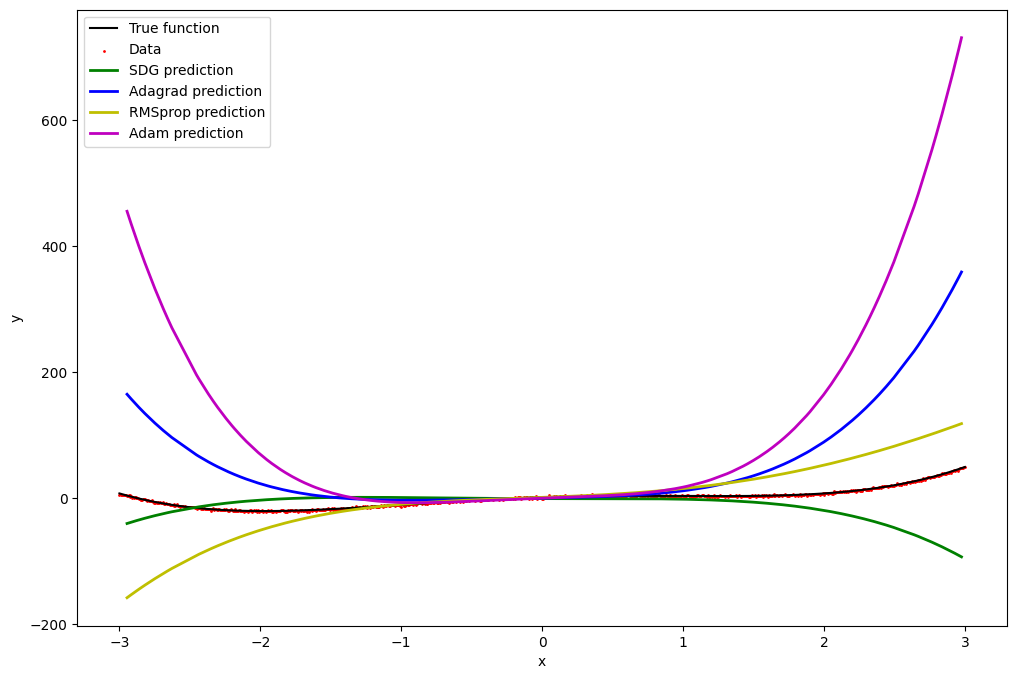

In [136]:
n_epochs = 50
mini_batch_size = 5
t0 = 5
t1 = 30
lmbda = 0.001
momentum = 0.2

beta_SDG = StochasticGradientDescent(X_train, y_train, M=mini_batch_size, n_epochs=n_epochs, lmbda=lmbda, momentum=momentum, learning_schedule_params=(t0, t1))
beta_adagrad = StochasticGradientDescent(X_train, y_train, M=mini_batch_size, n_epochs=n_epochs, lmbda=lmbda, momentum=momentum, learning_schedule_params=(t0, t1), optimizer='adagrad')
beta_rmsprop = StochasticGradientDescent(X_train, y_train, M=mini_batch_size, n_epochs=n_epochs, lmbda=lmbda, momentum=momentum, learning_schedule_params=(t0, t1), optimizer='rmsprop')
beta_adam = StochasticGradientDescent(X_train, y_train, M=mini_batch_size, n_epochs=n_epochs, lmbda=lmbda, learning_schedule_params=(t0, t1), optimizer='adam')

# Sort data for plotting
if include_intercept:
    indices = np.argsort(X_test[:, 1])
    x_test = X_test[:, 1][indices]
else:
    indices = np.argsort(X_test[:, 0])
    x_test = X_test[:, 0][indices]

indices = np.argsort(X_test[:, 1])

x_test = X_test[:, 1][indices]
y_SDG = X_test[indices] @ beta_SDG
y_adagrad = X_test[indices] @ beta_adagrad
y_rmsprop = X_test[indices] @ beta_rmsprop
y_adam = X_test[indices] @ beta_adam


# Plot data and prediction
plt.figure(figsize=(12, 8))
plt.plot(x, y_true, c='k', label='True function')
plt.scatter(x, y, s=1, c='r', label='Data')
plt.plot(x_test, y_SDG, c ='g', lw=2, label='SDG prediction')
plt.plot(x_test, y_adagrad, c ='b', lw=2, label='Adagrad prediction')
plt.plot(x_test, y_rmsprop, c ='y', lw=2, label='RMSprop prediction')
plt.plot(x_test, y_adam, c ='m', lw=2, label='Adam prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

## Discussion

Finding a fitting momentum is important. If, for instance, the momentum is too large, the optimization might swing right past the optimal estimator values. 

Increasing the minibatch size and the number of epoch allows for more iterations, but the learning rate gets very small for the last iterations, meaning there is not much benefit from setting these two parameters two high.
Adjusting the learning schedule parameters $t_0, t_1, t$ allows us to tune how fast the learning rate decay happens. If the fraction $\frac{t_0}{t_1}$ is too extreme, the model suffers as the learning rate is either too high or too low. If $t_0$ or $t_1$ have too large values, even though the ratio is reasonable, they make the contribution from $t$ negligible, even as it increases over epoch and mini-batch sizes.